# Reference-free automated single-cell cell type annotation

By 2025, algorithms for automated cell type annotation have proliferated. Omicverse is committed to reducing discrepancies between different algorithms, so we categorize automated annotation methods into two groups: `with single-cell reference` and `without single-cell reference`. Each category has its own advantages and disadvantages. In this tutorial, we will only cover usage and will not compare different algorithms.

This chapter focuses on `no single-cell reference` approaches, meaning cell type annotation can be performed without downloading existing single-cell datasets.

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set(font_path='Arial')

# Enable auto-reload for development
%load_ext autoreload
%autoreload 2

🔬 Starting plot initialization...
Using already downloaded Arial font from: /tmp/omicverse_arial.ttf


/home/groups/xiaojie/steorra/env/omicverse/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Registered as: Arial
🧬 Detecting GPU devices…
✅ NVIDIA CUDA GPUs detected: 1
    • [CUDA 0] NVIDIA H100 80GB HBM3
      Memory: 79.1 GB | Compute: 9.0

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.8rc2   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



## Data preprocess

### Load Dataset

To quickly demonstrate our capability for reference-free cell type annotation, we utilize the classic pbmc3k dataset. You can import it directly using `omicverse.datasets.pbmc3k` or download it via the link: https://falexwolf.de/data/pbmc3k_raw.h5ad.

In [2]:
adata=ov.datasets.pbmc3k()
adata

 Loading PBMC 3k dataset (raw)
🔍 Downloading data to ./data/pbmc3k_raw.h5ad



Downloading: 100%|█████████▉| 5.85M/5.86M [00:02<00:00, 2.90MB/s]

✅ Download completed
 Loading data from ./data/pbmc3k_raw.h5ad
✅ Successfully loaded: 2700 cells × 32738 genes


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Lazy Preprocess

Since the single dataset lacks batch effects, we directly applied the default processing workflow from omicverse for preprocessing.

In [3]:
#quantity control
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
#normalize and high variable genes (HVGs) calculated
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,target_sum=1e4)

#save the whole genes and filter the non-HVGs
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]

#scale the adata.X
ov.pp.scale(adata)

#Dimensionality Reduction
ov.pp.pca(adata,layer='scaled',n_pcs=50)

#Neighbourhood graph construction
ov.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
               use_rep='scaled|original|X_pca')

#clusters
ov.pp.leiden(adata)

#Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
ov.pp.umap(adata)
adata

🖥️ Using CPU mode for QC...

📊 Step 1: Calculating QC Metrics

   ✓ Gene Family Detection:
   ┌──────────────────────────────┬────────────────────┬────────────────────┐
   │ Gene Family                  │ Genes Found        │ Detection Method   │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Mitochondrial                │ 13                 │ Auto (MT-)         │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Ribosomal                    │ 106                │ Auto (RPS/RPL)     │
   ├──────────────────────────────┼────────────────────┼────────────────────┤
   │ Hemoglobin                   │ 13                 │ Auto (regex)       │
   └──────────────────────────────┴────────────────────┴────────────────────┘

   ✓ QC Metrics Summary:
   ┌─────────────────────────┬────────────────────┬─────────────────────────┐
   │ Metric                  │ Mean               │ Range (Min - Max)       │
   ├─────────────────────

AnnData object with n_obs × n_vars = 2598 × 2000
    obs: 'nUMIs', 'mito_perc', 'ribo_perc', 'hb_perc', 'detected_genes', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden'
    var: 'gene_ids', 'mt', 'ribo', 'hb', 'n_cells', 'percent_cells', 'robust', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'scrublet', 'status', 'status_args', 'REFERENCE_MANU', 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'scaled|original|X_pca', 'X_umap'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled'
    obsp: 'distances', 'connectivities'

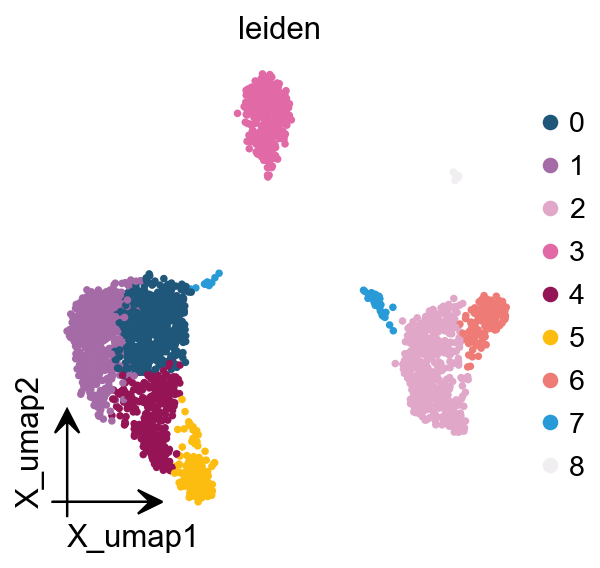

In [5]:
ov.pl.umap(
    adata,
    color='leiden'
)

## Automated Annotation

We have unified all automatic annotation algorithms into the `omicverse.single.Annotation` class.

In [7]:
obj=ov.single.Annotation(adata)

### Celltypist Automated Annotation

Here, we introduce the first algorithm, Celltypist, published in Cell and Science, which we have integrated into the automatic annotation module of Omicverse. It is important to note that to obtain the optimal pre-trained model, we have incorporated Agent for query processing.

In [8]:
res=obj.query_reference(
    source='celltypist',
    data_desc='pbmc of human',
    llm_model='gpt-5-mini',
    llm_api_key='sk-*',
    llm_provider='openai',
    llm_base_url='https://api.openai.com/v1',
)
res.head()

CellTypist model table saved to self.celltypist_models_df
✓ LLM-selected CellTypist models:
  - Immune_All_Low.pkl: Immune_All_Low.pkl
  - Immune_All_High.pkl: Immune_All_High.pkl
  - Healthy_COVID19_PBMC.pkl: Healthy_COVID19_PBMC.pkl
  - Adult_COVID19_PBMC.pkl: Adult_COVID19_PBMC.pkl
  - PaediatricAdult_COVID19_PBMC.pkl: PaediatricAdult_COVID19_PBMC.pkl


,model,description,version,No_celltypes,source,date,default,llm_reason
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...,v2,98,https://doi.org/10.1126/science.abl5197,2022-07-16 00:20:42.927778,True,High-resolution immune reference (98 immune su...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...,v2,32,https://doi.org/10.1126/science.abl5197,2022-07-16 08:53:00.959521,NaN,Compact immune reference (32 broad immune popu...
2,Healthy_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from h...,v1,51,https://doi.org/10.1038/s41591-021-01329-2,2022-03-10 05:08:08.224597,NaN,PBMC-specific reference derived from healthy a...
3,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...,v1,20,https://doi.org/10.1038/s41591-020-0944-y,2024-06-24 19:37:48.634397,NaN,PBMC reference from adult human donors (COVID-...
4,PaediatricAdult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types of pae...,v1,42,https://doi.org/10.1038/s41586-021-04345-x,2025-10-15 00:51:41.857714,NaN,PBMC reference spanning pediatric and adult hu...


Based on the LLM's recommendation, we found that `Immune_All_Low.pkl` is the model best suited for our data. Then we use `download_reference_pkl` function to download this model.

In [9]:
!pwd

/scratch/users/steorra/analysis/omic_test


In [12]:
obj.download_reference_pkl(
    'Immune_All_Low.pkl',
    save_path="/scratch/users/steorra/analysis/omic_test/models/Immune_All_Low.pkl",
    #force_download=True
)

🔍 Downloading data to /scratch/users/steorra/analysis/omic_test/models/Immune_All_Low.pkl


Downloading: 100%|█████████▉| 2.82M/2.82M [00:01<00:00, 1.90MB/s]

✅ Download completed
https://celltypist.cog.sanger.ac.uk/models/Pan_Immune_CellTypist/v2/Immune_All_Low.pkl
✓ Model saved to /scratch/users/steorra/analysis/omic_test/models/Immune_All_Low.pkl


'/scratch/users/steorra/analysis/omic_test/models/Immune_All_Low.pkl'

After download the model, we need to load it to our Annotation class.

In [14]:
obj.add_reference_pkl('/scratch/users/steorra/analysis/omic_test/models/Immune_All_Low.pkl')

In [16]:
obj.model.cell_types[:5]

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells'], dtype=object)

In [17]:
obj.annotate(
    method='celltypist'
)

running Leiden clustering
    finished: found 55 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:00)
Celltypist prediction saved to adata.obs['celltypist_prediction']
Celltypist decision matrix saved to adata.obsm['celltypist_decision_matrix']
Celltypist probability matrix saved to adata.obsm['celltypist_probability_matrix']


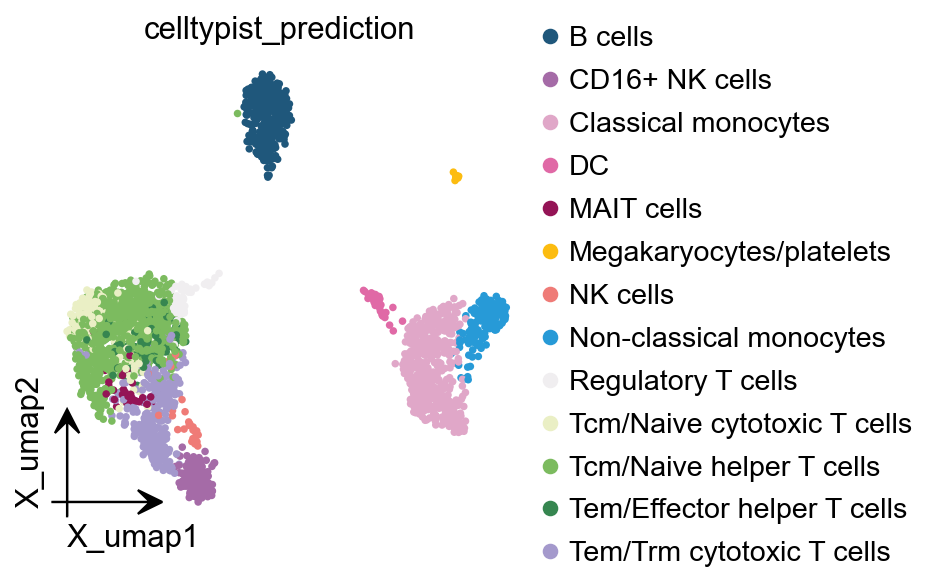

In [18]:
ov.pl.embedding(
    obj.adata,
    basis='X_umap',
    color='celltypist_prediction'
)

### gpt4celltype Automated Annotation

Besides, we also provide the gpt4celltype to annotate the celltype automatically. 

In [20]:
import os
os.environ['AGI_API_KEY'] = 'sk-*'  # Replace with your actual API key

obj=ov.single.Annotation(adata)
result = obj.annotate(
    method='gpt4celltype',
    tissuename='PBMC', speciename='human',
    model='gpt-5-mini', provider='openai',
    topgenenumber=5 
)


...get cell type marker
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
Note: AGI API key found: returning the cell type annotations.
Note: It is always recommended to check the results returned by GPT-4 in case of AI hallucination, before going to downstream analysis.
GPT4celltype prediction saved to adata.obs['gpt4celltype_prediction']


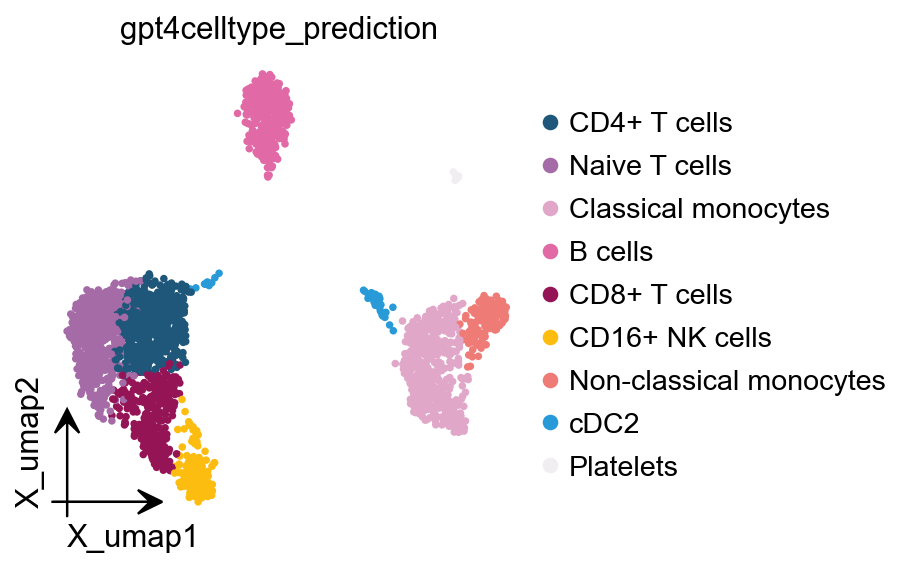

In [21]:
ov.pl.embedding(
    obj.adata,
    basis='X_umap',
    color='gpt4celltype_prediction'
)

### SCSA Automated Annotation

We haved a clearly detailed tutorial of SCSA in https://omicverse.readthedocs.io/en/latest/Tutorials-single/t_cellanno/

Here, we only provided a simple tutorial to demonstrate the ability of Annotation class.

In [ ]:
obj=ov.single.Annotation(adata)

To perform the SCSA automated annotation, we need to download the database at first.

In [22]:
obj.download_scsa_db(
    'temp/pySCSA_2024_v1_plus.db'
)

🔍 Downloading data to temp/pySCSA_2024_v1_plus.db


Downloading: 100%|█████████▉| 14.8M/14.8M [00:14<00:00, 1.03MB/s]

✅ Download completed
SCSA database saved to temp/pySCSA_2024_v1_plus.db


'temp/pySCSA_2024_v1_plus.db'

In [23]:
obj.add_reference_scsa_db(
    'temp/pySCSA_2024_v1_plus.db'
)

In [24]:
obj.annotate(
    method='scsa',
    cluster_key='leiden',
    foldchange=1.5,
    pvalue=0.01,
    celltype='normal',
    target='cellmarker',
    tissue='All',  
)

ranking genes
    finished (0:00:00)
...Auto annotate cell
🔍 Version V2.2 [2024/12/18]
📊 DB load: GO_items:47347, Human_GO:3, Mouse_GO:3,
           CellMarkers:82887, CancerSEA:1574, PanglaoDB:24223
           Ensembl_HGNC:61541, Ensembl_Mouse:55414
🔍 Version V2.2 [2024/12/18]
📊 DB load: GO_items:47347, Human_GO:3, Mouse_GO:3,
           CellMarkers:82887, CancerSEA:1574, PanglaoDB:24223
           Ensembl_HGNC:61541, Ensembl_Mouse:55414
📦 Load markers: 70276

🔬 Analyzing 9 clusters...

[1/9]      Cluster 0    │ 48   genes │ 988  other genes
[2/9]      Cluster 1    │ 29   genes │ 1006 other genes
[3/9]      Cluster 2    │ 346  genes │ 930  other genes
[4/9]      Cluster 3    │ 118  genes │ 946  other genes
[5/9]      Cluster 4    │ 51   genes │ 1011 other genes
[6/9]      Cluster 5    │ 160  genes │ 934  other genes
[7/9]      Cluster 6    │ 429  genes │ 865  other genes
[8/9]      Cluster 7    │ 274  genes │ 890  other genes
[9/9]      Cluster 8    │ 144  genes │ 944  other genes

✅ 

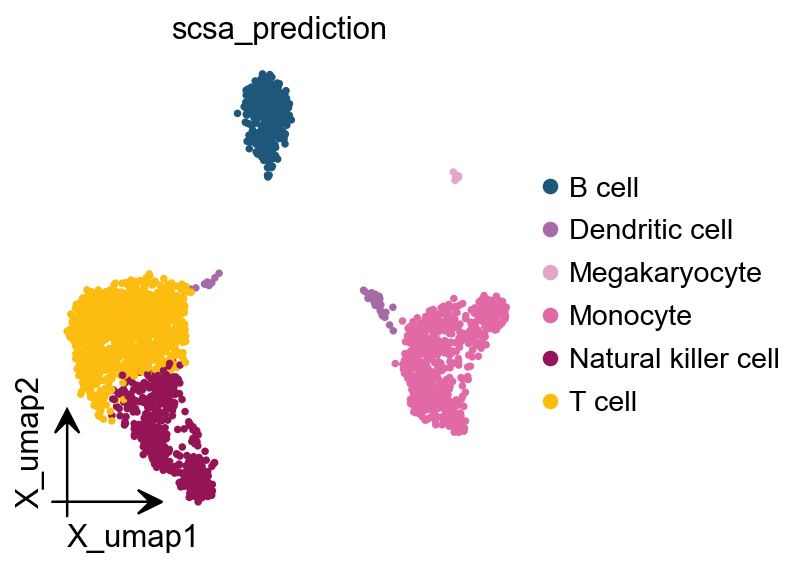

In [25]:
ov.pl.embedding(
    obj.adata,
    basis='X_umap',
    color='scsa_prediction'
)